In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

In [5]:
# 데이터셋 로드
# 평점(rating)이 포함된 데이터셋
df =  pd.read_csv('/content/drive/MyDrive/last_csv')

# 불필요한 칼럼 제거
df = df.drop(['Unnamed: 0'], axis=1)

In [6]:
df

,product_id,category_id,brand,price,user_id,division1,division2,rating
0,1307067,2053013558920217191,lenovo,251.74,550050854,computers,notebook,1.5
1,1004237,2053013555631882655,apple,1081.98,535871217,electronics,smartphone,1.5
2,1004545,2053013555631882655,huawei,566.01,537918940,electronics,smartphone,1.5
3,2900536,2053013554776244595,elenberg,51.46,555158050,appliances,kitchen,1.5
4,1005011,2053013555631882655,samsung,900.64,530282093,electronics,smartphone,1.5
...,...,...,...,...,...,...,...,...
17292888,1002786,2053013555631882655,unknown,391.26,512789086,electronics,smartphone,1.5
17292889,1005008,2053013555631882655,xiaomi,94.46,557202408,electronics,smartphone,1.5
17292890,1003936,2053013555631882655,xiaomi,437.33,520088904,electronics,smartphone,1.5
17292891,1004870,2053013555631882655,samsung,275.25,518956209,electronics,smartphone,1.5


In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 7.0 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633978 sha256=c2171eb74d0a183b619bc932089cb2e5e16c876216f8fc67dd9cd24485ac344f
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
from surprise import SVD, BaselineOnly, SVDpp, Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import KNNBaseline
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic
from surprise import accuracy
from surprise import dump
from surprise.model_selection import KFold
from surprise import NormalPredictor
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from surprise.model_selection import train_test_split

In [ ]:
# surprise 모듈의 훈련,테스트 모듈 나누는것과 비슷한 방법으로 데이터 분리 진행

# train, test split

# 데이터 랜덤하게 섞기
df_r_m = df.sample(frac=1)

# 7:3 비율로 나누기
cutoff = int(.7 * len(df_r_m))
train_r = df_r_m[:cutoff]
test_r = df_r_m[cutoff:]


train_r = train_r[['user_id', 'product_id', 'rating', 'division2', 'brand']]
test_r = test_r[['user_id', 'product_id', 'rating', 'division2', 'brand']]
print("train_size:", len(train_r), "test_size:", len(test_r))

train_r.head()

train_size: 12105025 test_size: 5187868


,user_id,product_id,rating,division2,brand
896869,540918966,1004435,3.4,smartphone,samsung
4552419,551524478,1005157,1.5,smartphone,xiaomi
15996779,553766949,3600934,3.4,kitchen,indesit
4389360,538719653,1004768,5.0,smartphone,samsung
16517480,548753868,16800584,1.5,kitchen,mebelswow-rn


In [ ]:
def convert_traintest_dataframe_forsurprise(training_dataframe, testing_dataframe):
    reader = Reader(rating_scale=(1, 5))
    trainset = Dataset.load_from_df(training_dataframe[['user_id', 'product_id', 'rating']], reader)
    testset = Dataset.load_from_df(testing_dataframe[['user_id', 'product_id', 'rating']], reader)
    
    trainset = trainset.construct_trainset(trainset.raw_ratings)
    testset = testset.construct_testset(testset.raw_ratings)
    
    return trainset, testset

trainset, testset = convert_traintest_dataframe_forsurprise(train_r, test_r)

In [ ]:
# content-based filtering (CBF)
# reference: https://surprise.readthedocs.io/en/stable/knn_inspired.html


sim_options = {'name': 'cosine',
               'user_based': False  # content(item)-based similarity
               }
knnbaseline_algo_i = KNNBaseline(sim_options=sim_options)

knnbaseline_algo_i.fit(trainset)
knnbaseline_predictions_i = knnbaseline_algo_i.test(testset)

accuracy.rmse(knnbaseline_predictions_i)
accuracy.mae(knnbaseline_predictions_i)
print("Done!")

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3829
MAE:  0.1846
Done!


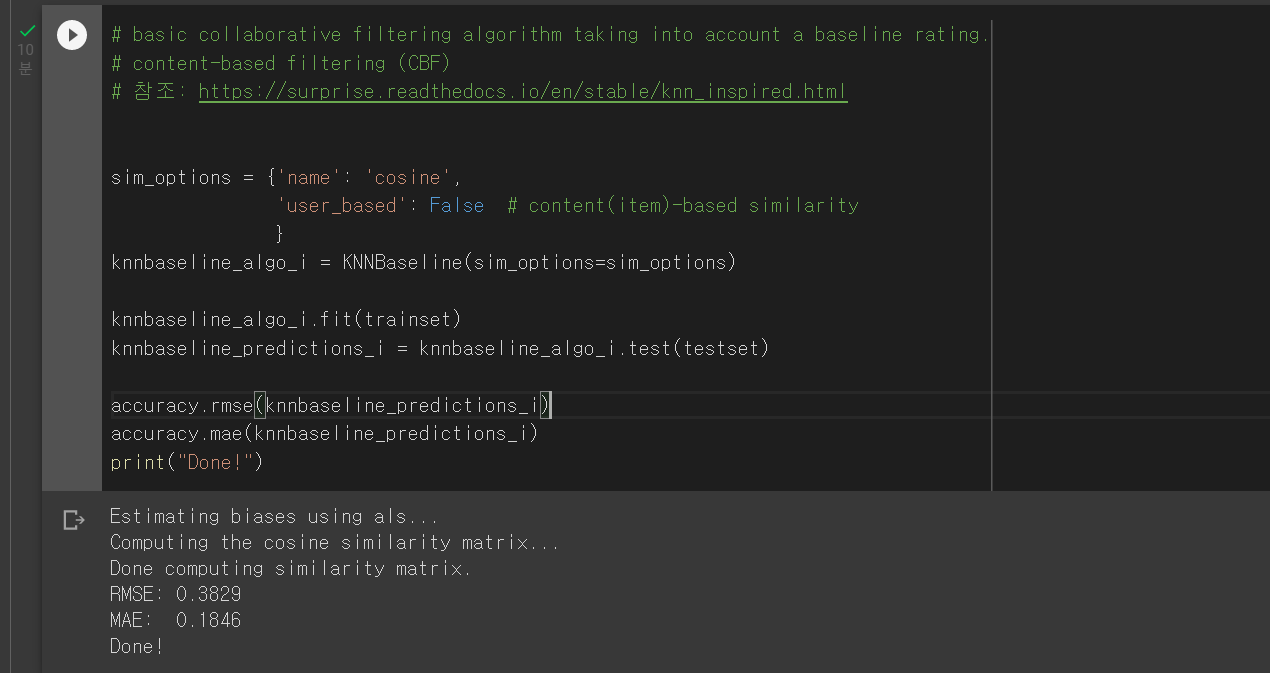

KNN 모델 : 약 10분 소요

**surprise 라이브러리

test()는 사용자-아이템 평점 데이터 세트 전체에 대해서 추천을 예측하는 메서드. 즉 입력된 데이터 세트에 대해 추천 데이터 세트를 만들어준다.

predict()는 개별 사용자와 영화에 대한 추천 평점을 반환해준다.

uid(개별 사용자 아이디), 아이템(iid), 실제 평점(r_ui), 정보에 기반한 surprise의 추천 예측 평점(est)

details 속성은 내부 처리 시 추천 예측을 할 수 없는 경우에 로그용으로 데이터를 남기는데 사용된다. (was_impossible이 True이면 예측값을 생성할 수 없는 데이터 라는 의미)

리스트 객체 내에 내포된 Prediction 개체의 uid, iid, r_ri, est 등의 속성에 접근하려면 객체명.uid와 같은 형식으로 가능하다.

In [ ]:
## svd 
 ## 참고: https://surprise.readthedocs.io/en/stable/matrix_factorization.html#matrix-factorization-based-algorithms

svd_algo = SVD()

svd_algo.fit(trainset)
svd_predictions = svd_algo.test(testset)


accuracy.rmse(svd_predictions)
accuracy.mae(svd_predictions)
print("Done!")

RMSE: 0.5347
MAE:  0.4126
Done!


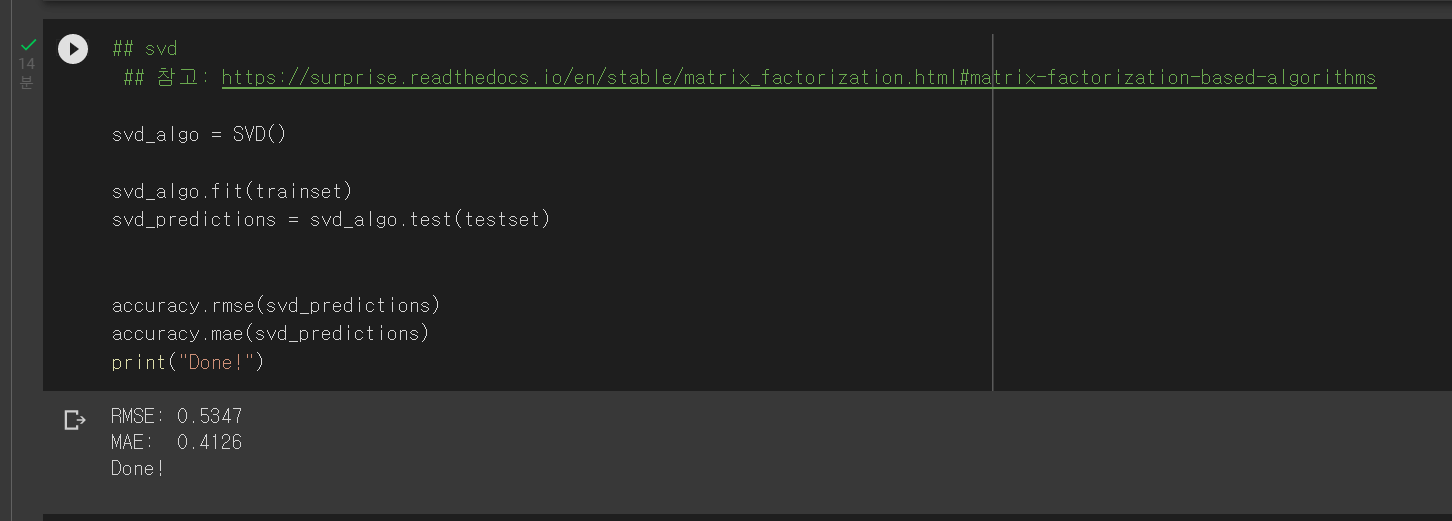

SVD 모델 : 약 14분 소요

In [ ]:
# matrix factorization/ collaborative filtering(CF)
 ## svd++ model : taking into account implicit ratings 
 ## 참고: https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp

svdpp_algo = SVDpp()

svdpp_algo.fit(trainset)
svdpp_predictions = svdpp_algo.test(testset)

file_name = 'svdpp_model'
dump.dump(file_name, algo=svdpp_algo)
# _, loaded_algo = dump.load(file_name)

accuracy.rmse(svdpp_predictions)
accuracy.mae(svdpp_predictions)
print("Done!")

RMSE: 2.8325
MAE:  2.4451
Done!


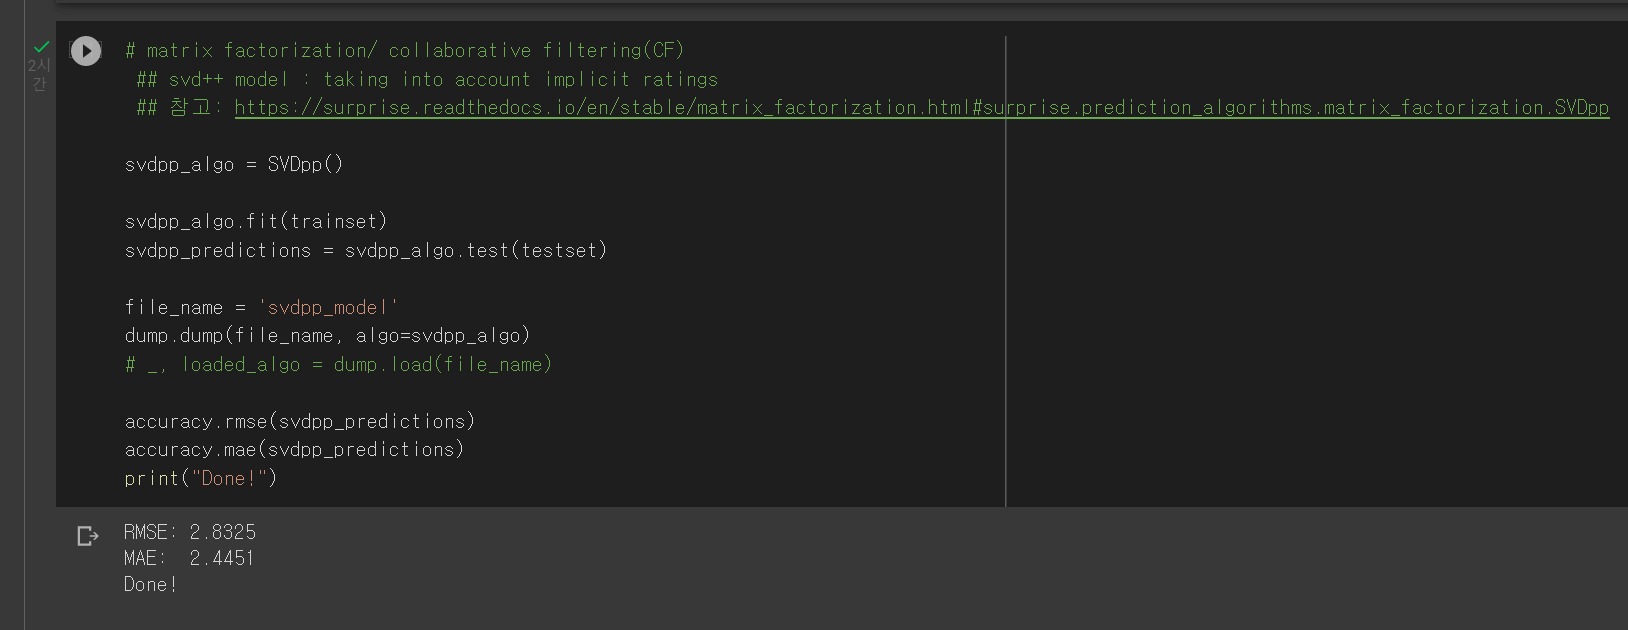

SVD++ 모델 : 약 2시간 소요

predict()를 사용한 예측 

개별 사용자의 아이템에 대한 추천 평점을 예측해준다. 

인자로 개별 사용자 아이디, 아이템 아이디를 입력하면 추천 예측 평점을 포함한 정보를 반환한다. (사용자 아이디, 아이템 아이디는 문자열로 입력해야 한다)

In [ ]:
# predictions 
knn_i_pred = knnbaseline_algo_i.test(testset)
svd_pred = svd_algo.test(testset)
svdpp_pred = svdpp_algo.test(testset)

In [ ]:
# test_rmse, test_mae
knn_i_rmse = accuracy.rmse(knn_i_pred)
knn_i_mae = accuracy.mae(knn_i_pred)
svd_rmse = accuracy.rmse(svd_pred)
svd_mae = accuracy.mae(svd_pred)
svdpp_rmse = accuracy.rmse(svdpp_pred)
svdpp_mae = accuracy.mae(svdpp_pred)

RMSE: 0.3829
MAE:  0.1846
RMSE: 0.5347
MAE:  0.4126
RMSE: 2.8325
MAE:  2.4451


In [ ]:
# recall & precision @ k function
# 참고: https://surprise.readthedocs.io/en/stable/FAQ.html?highlight=recall#how-to-compute-precision-k-and-recall-k

from collections import defaultdict
from surprise import Dataset
from surprise import SVD
from surprise.model_selection import KFold


def precision_recall_at_k(predictions, k, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [ ]:
# knn_i 모델 precision&recall
knn_i_prec, knn_i_re = precision_recall_at_k(knn_i_pred, k=5, threshold=4)

# Precision and recall can then be averaged over all users
knn_i_prec_avg = sum(prec for prec in knn_i_prec.values()) / len(knn_i_prec)
print(knn_i_prec_avg)
knn_i_re_avg = sum(rec for rec in knn_i_re.values()) / len(knn_i_re)
print(knn_i_re_avg)

0.10863560329330568
0.08356015226078108


In [ ]:
# svd precision&recall
svd_prec, svd_re = precision_recall_at_k(svd_pred, k=5, threshold=4)

# Precision and recall can then be averaged over all users
svd_prec_avg = sum(prec for prec in svd_prec.values()) / len(svd_prec)
print(svd_prec_avg)
svd_re_avg = sum(rec for rec in svd_re.values()) / len(svd_re)
print(svd_re_avg)

0.08774934447982571
0.053659641026884884


In [ ]:
# svdpp precision&recall
svdpp_prec, svdpp_re = precision_recall_at_k(svdpp_pred, k=5, threshold=4)

# Precision and recall can then be averaged over all users
svdpp_prec_avg = sum(prec for prec in svdpp_prec.values()) / len(svdpp_prec)
print(svdpp_prec_avg)
svdpp_re_avg = sum(rec for rec in svdpp_re.values()) / len(svdpp_re)
print(svdpp_re_avg)

0.10826704226955672
0.08564337498879968


In [ ]:
# model별 test prediction  데이터 
# row: Knnbaseline(item based), Knnbaseline(user based), SVD(CF), SVDpp(CF), gridsearch(SVDpp)
# columns: test RMSE, test MAE, test_time, Precision, recall
# hybrid 모델 수치는 SVDpp(CF)모델과 Knnbaseline(item-based)의 평균값. 

test_prediction = pd.DataFrame({"Algorithm": ["KnnBaseline(item-based)" ,  
                                              "SVD(CF)",
                                              "SVDpp(CF)"]
                                ,"test_rmse": [knn_i_rmse , svd_rmse , svdpp_rmse]
                                ,"test_mae":[knn_i_mae , svd_mae, svdpp_mae]
                                ,"Precision":[knn_i_prec_avg ,svd_prec_avg ,svdpp_prec_avg]
                                ,"recall":[knn_i_re_avg ,svd_re_avg ,svdpp_re_avg]
                                })

test_prediction

,Algorithm,test_rmse,test_mae,Precision,recall
0,KnnBaseline(item-based),0.382866,0.184574,0.108636,0.083560
1,SVD(CF),0.534720,0.412619,0.087749,0.053660
2,SVDpp(CF),2.832530,2.445112,0.108267,0.085643


책 참고, 알고리즘 성능 비교

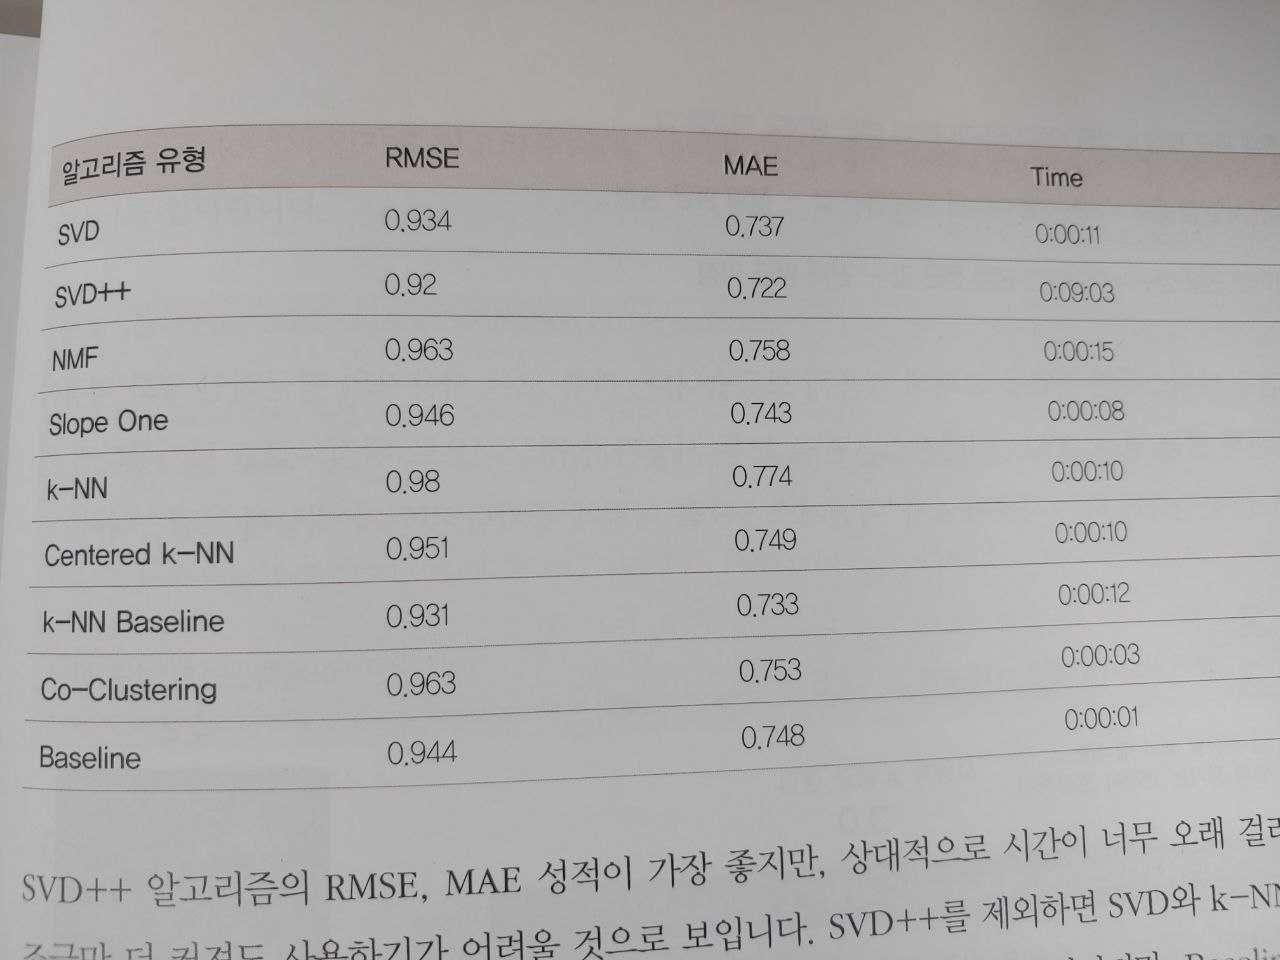